In [ ]:
!pip install mne
#MNE (MNE-Python) is a Python package for working with EEG

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 20.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from scipy.io import loadmat
data = loadmat('/content/drive/MyDrive/Capstone/ADHD/v40p.mat')

In [ ]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Apr 12 15:32:42 2020',
 '__version__': '1.0',
 '__globals__': [],
 'v40p': array([[ -653,   -90, -1161, ..., -1146,   156, -1287],
        [ -618,  -160, -1124, ..., -1181,   121, -1251],
        [ -653,  -160, -1124, ..., -1075,   156, -1146],
        ...,
        [ 1775,   578,  1856, ...,  1986,   191,  1529],
        [ 1705,   508,  1856, ...,  2127,   226,  1705],
        [ 1669,   473,  2003, ...,  2021,   191,  1634]], dtype=int16)}

In [ ]:
#data from .mat file is a dictionary , the readings are stored under file name as key, v40p is a sample filename used
eeg_data = data['v40p']
#we transpose as we require the data to be in the form of (num_channels,num_samles)
eeg_data=eeg_data.transpose()
eeg_data.shape

(19, 20097)

In [ ]:
import numpy as np
import mne

# eeg_data is a numpy array with shape (n_channels, n_samples)
#channel_names provided in dataset
ch_names = ['Fz', 'Cz', 'Pz', 'C3', 'T3', 'C4', 'T4', 'Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'P3', 'P4', 'T5', 'T6', 'O1', 'O2']  # List of channel names
sfreq = 128  # Sampling frequency also provided in dataset

# Create MNE info structure
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')

# Create MNE Raw object
raw = mne.io.RawArray(data=eeg_data, info=info)


Creating RawArray with float64 data, n_channels=19, n_times=20097
    Range : 0 ... 20096 =      0.000 ...   157.000 secs
Ready.


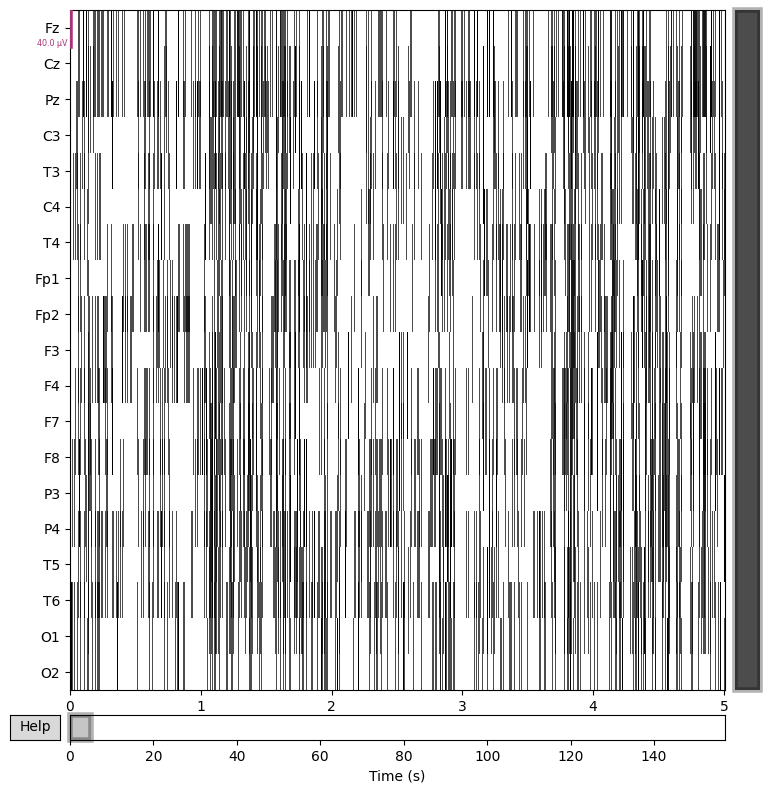

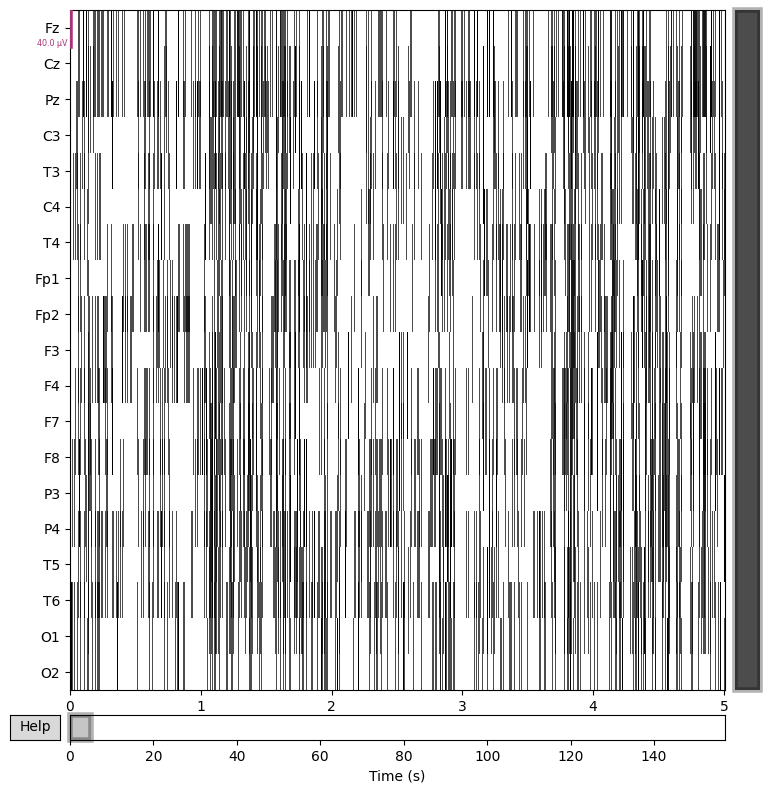

In [ ]:
raw.plot(duration=5, n_channels=19)


In [ ]:
import scipy.io
import pandas as pd

# Load .mat file
mat_file = '/content/drive/MyDrive/Capstone/ADHD/v40p.mat'  # Update with the path to your .mat file
data = scipy.io.loadmat(mat_file)
#eeg_data = data['v3p']


# Extract EEG data from the loaded data
eeg_data = data['v40p']  # Update with the appropriate variable name

# Convert EEG data to a Pandas DataFrame
df = pd.DataFrame(eeg_data)

# Export DataFrame to CSV
csv_output = 'output_file.csv'  # Update with the desired CSV file name
df.to_csv(csv_output, index=False)


In [ ]:
len(df)


20097

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-653,-90,-1161,50,-1235,126,-1087,126,-756,200,-1161,89,-1198,200,-940,236,-1146,156,-1287
1,-618,-160,-1124,50,-1198,236,-1051,200,-830,200,-1161,89,-1198,163,-940,200,-1181,121,-1251
2,-653,-160,-1124,50,-1087,163,-1014,163,-903,273,-1087,89,-1124,163,-903,163,-1075,156,-1146
3,-547,-160,-940,50,-867,126,-867,163,-756,273,-903,16,-940,89,-719,200,-899,85,-935
4,-477,-301,-756,-55,-719,89,-719,163,-572,200,-756,-94,-830,52,-609,200,-759,85,-759


In [ ]:
import numpy as np
from scipy.signal import filtfilt, iirnotch

# Function to apply thresholding and artifact replacement
def preprocess_channel(channel_data, threshold_factor=5):
    iqr = np.percentile(channel_data, 75) - np.percentile(channel_data, 25)
    lower_threshold = np.median(channel_data) - threshold_factor * iqr
    upper_threshold = np.median(channel_data) + threshold_factor * iqr

    exceeding_lower = np.where(channel_data < lower_threshold)
    exceeding_upper = np.where(channel_data > upper_threshold)

    channel_data[exceeding_lower] = lower_threshold
    channel_data[exceeding_upper] = upper_threshold

    for idx in np.concatenate((exceeding_lower[0], exceeding_upper[0])):
        if idx > 0 and idx < len(channel_data) - 1:
            channel_data[idx] = (channel_data[idx - 1] + channel_data[idx + 1]) / 2

    return channel_data

# Apply preprocessing steps
preprocessed_data = np.apply_along_axis(preprocess_channel, axis=1, arr=eeg_data)

# Apply zero-phase digital notch filter at 60 Hz
def apply_notch_filter(data, fs=128, freq=60, q=30):
    b, a = iirnotch(freq, q, fs=fs)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

preprocessed_data_notch = apply_notch_filter(preprocessed_data)

# Apply differential filter to remove very low-frequency components
def apply_differential_filter(data):
    differential_data = np.diff(data, axis=1)
    return differential_data

preprocessed_data_filtered = apply_differential_filter(preprocessed_data_notch)

# Now 'preprocessed_data_filtered' contains the EEG data after applying all preprocessing steps


In [ ]:
preprocessed_data_filtered

array([[  709.95482462, -1005.85706397,   936.54483342, ...,
         -947.92590861,  1101.59123209, -1497.80065772],
       [  601.14281765,  -892.61131167,   890.18962986, ...,
         -953.25058179,  1109.1240465 , -1434.85930014],
       [  628.41701582,  -893.66866406,   900.45264699, ...,
         -830.88786754,  1048.56960687, -1363.69619281],
       ...,
       [-1350.5799895 ,  1164.95594797, -1115.5615431 , ...,
         1324.3642941 , -1583.83505463,  1438.90416567],
       [-1362.22337471,  1245.560064  , -1124.73698644, ...,
         1477.43323098, -1670.64554233,  1568.79179565],
       [-1361.08202865,  1431.78353547, -1281.62021388, ...,
         1340.72819432, -1599.41326973,  1525.3633912 ]])

In [ ]:
df1 = pd.DataFrame(preprocessed_data_filtered)
df1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,709.954825,-1005.857064,936.544833,-812.532922,708.776338,-405.007796,277.588589,149.460263,-138.110014,-240.904652,144.331797,-237.517305,446.277506,-326.004979,535.913592,-947.925909,1101.591232,-1497.800658
1,601.142818,-892.611312,890.189630,-762.822372,766.026385,-461.192940,296.948762,19.566374,-80.097133,-228.231319,135.453613,-232.546592,408.052634,-291.019102,504.442535,-953.250582,1109.124046,-1434.859300
2,628.417016,-893.668664,900.452647,-671.041762,608.922179,-383.783232,259.354675,-55.308441,106.734974,-269.878400,105.027300,-201.322085,374.052632,-289.349807,459.362017,-830.887868,1048.569607,-1363.696193
3,495.841311,-718.160159,759.666531,-527.294194,458.251850,-332.212162,266.441525,-79.254084,142.211573,-273.956236,35.037986,-122.942274,278.784228,-170.934853,422.301703,-766.964010,837.522965,-1074.768405
4,268.017414,-413.880333,526.690450,-362.266999,389.287527,-287.015425,277.263308,-67.842416,65.577059,-235.430535,-46.280267,-65.980448,275.845734,-143.566414,402.907359,-684.777962,719.567044,-882.863090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20092,-1345.368193,1069.482503,-1212.412101,1024.058080,-961.292868,799.441608,-347.546293,162.074077,-467.649768,200.802461,271.920008,-33.485903,-289.585097,437.766380,-812.640773,1424.225915,-1839.917301,1708.536967
20093,-1244.812988,1123.884566,-1203.153325,909.990274,-881.404576,721.466636,-270.268698,156.537431,-495.506635,223.265723,218.247751,15.381183,-297.819107,478.610352,-849.556729,1347.589511,-1691.472492,1555.520254
20094,-1350.579989,1164.955948,-1115.561543,906.674573,-816.778560,664.465055,-217.412151,33.013680,-481.365916,205.975085,239.809515,23.723588,-296.668932,542.111928,-940.581488,1324.364294,-1583.835055,1438.904166
20095,-1362.223375,1245.560064,-1124.736986,877.786809,-820.977087,627.984197,-103.350301,22.482785,-429.000048,221.974038,118.402397,-4.794877,-303.728409,549.210101,-912.258866,1477.433231,-1670.645542,1568.791796


In [ ]:
preprocessed_data_filtered=preprocessed_data_filtered.transpose()
preprocessed_data_filtered.shape

(18, 20097)

In [ ]:
N = len(preprocessed_data_filtered)
f_s = 128           # sampling frequency (Hz)
T_s = 1 / f_s         # sampling period (s)
t = T_s * N           # length of the data in seconds
t_vec  = np.arange(0, t, T_s) # array of numbers for seconds from 0 to t


Text(0.5, 1.0, 'Raw EEG Signal in Time Domain')

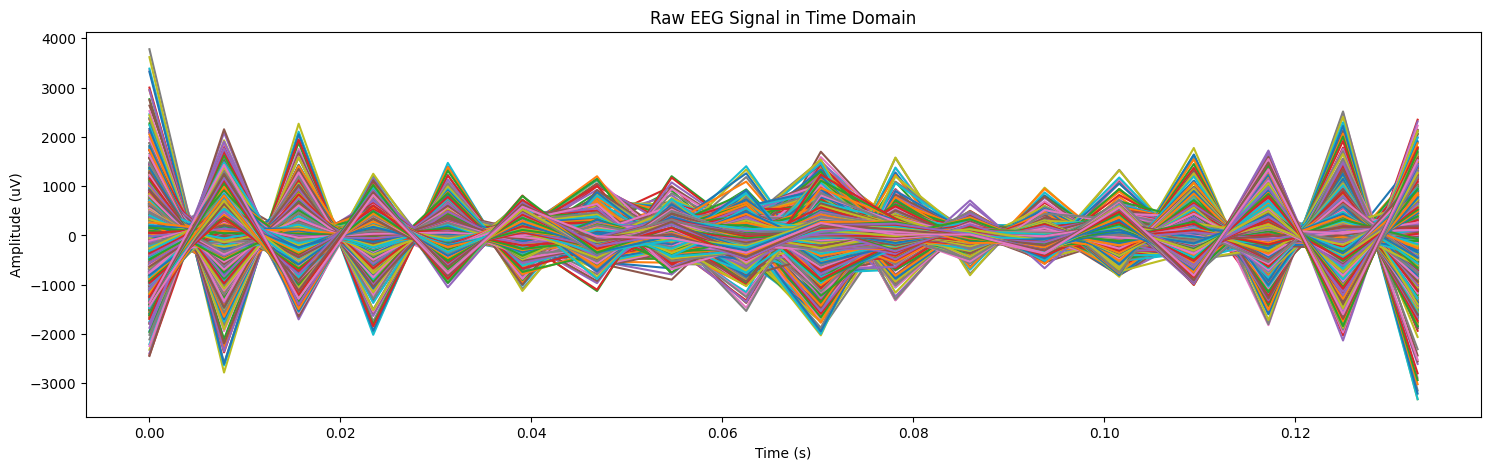

In [ ]:
import matplotlib.pyplot as plt
import numpy as np





fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(18)
plt.plot(t_vec, preprocessed_data_filtered)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.title('Raw EEG Signal in Time Domain')

ValueError: ignored

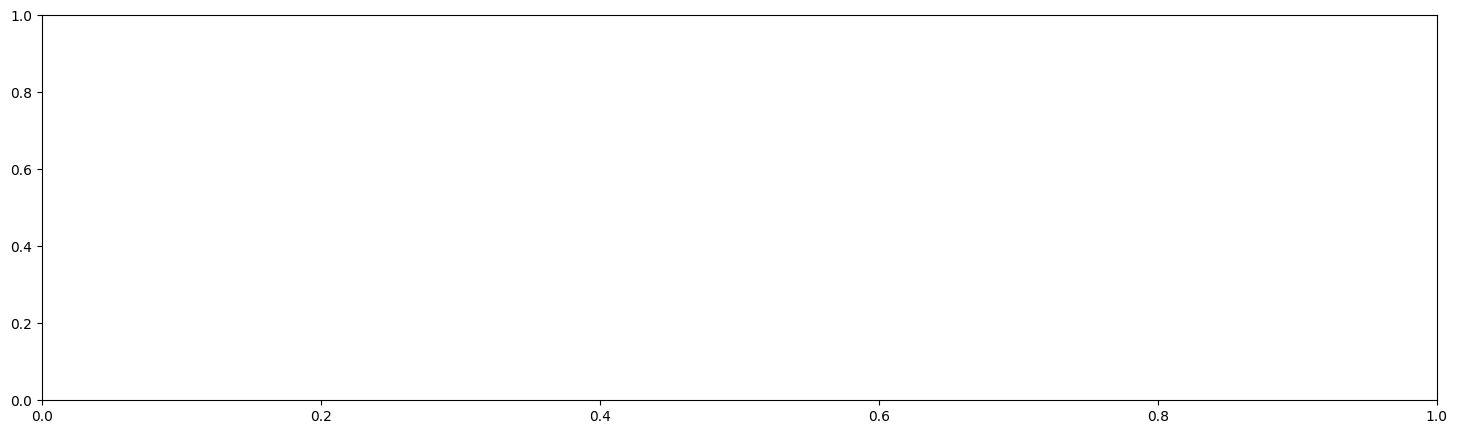

In [ ]:
import scipy.fftpack as fft
import numpy as np
import matplotlib.pyplot as plt

def my_fft(eeg):
    eeg_fft = fft.fft(eeg)
    amplitude = np.abs(eeg_fft)
    sample_freq = fft.fftfreq(eeg.size, d=T_s)
    return amplitude, sample_freq, eeg_fft

amplitude_eeg, sample_freq_eeg, eeg_fft = my_fft(preprocessed_data_filtered)

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(18)
plt.plot(sample_freq_eeg[:len(sample_freq_eeg)//2], amplitude_eeg[:len(amplitude_eeg)//2])  # Plot only positive frequencies
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (uV)')
plt.title('Raw EEG Signal in Frequency Domain')
plt.grid()
plt.show()



In [ ]:
import numpy as np
import mne

# eeg_data is a numpy array with shape (n_channels, n_samples)
#channel_names provided in dataset
ch_names = ['Fz', 'Cz', 'Pz', 'C3', 'T3', 'C4', 'T4', 'Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'P3', 'P4', 'T5', 'T6', 'O1']  # List of channel names
sfreq = 128  # Sampling frequency also provided in dataset

# Create MNE info structure
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')

# Create MNE Raw object
raw = mne.io.RawArray(data=preprocessed_data_filtered, info=info)

Creating RawArray with float64 data, n_channels=18, n_times=20097
    Range : 0 ... 20096 =      0.000 ...   157.000 secs
Ready.


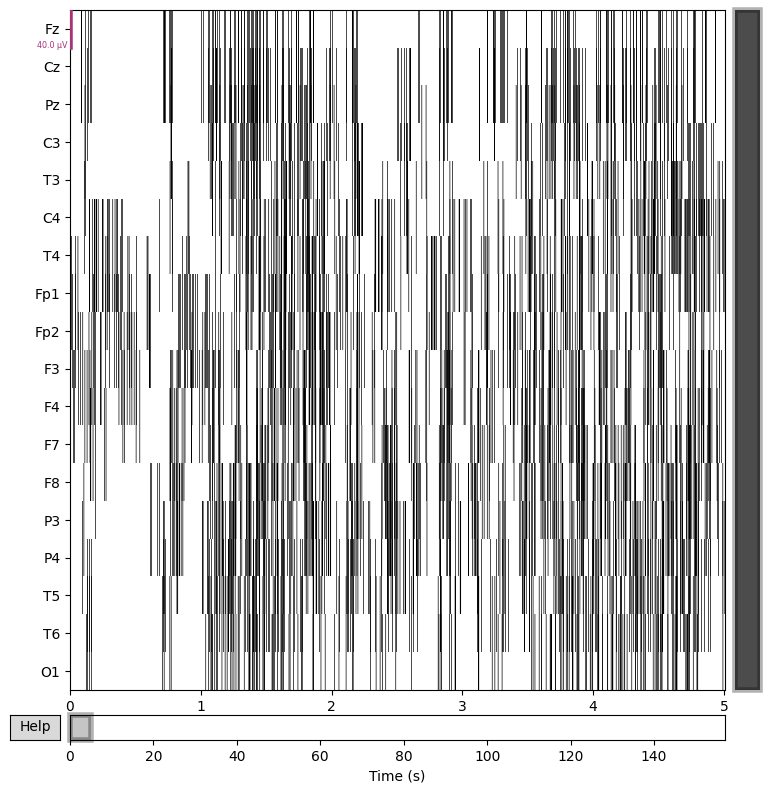

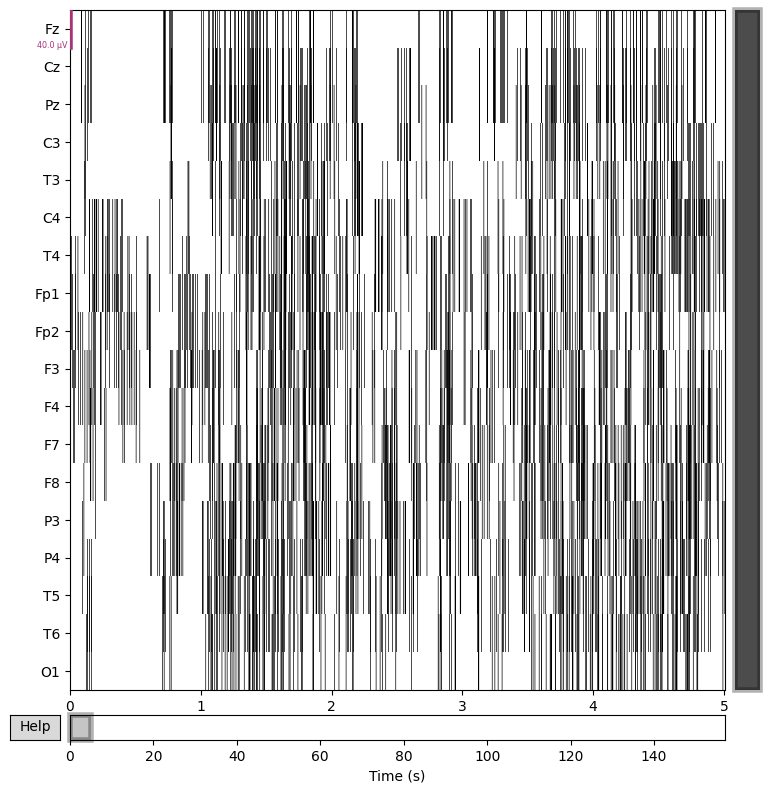

In [ ]:
raw.plot(duration=5, n_channels=19)


In [ ]:
from glob import glob
import os
import mne
import numpy as np
import pandas
import matplotlib.pyplot as plt

In [ ]:
#accessing the dataest with glob
patient_file_path=glob("/content/drive/MyDrive/Capstone/ADHD/*.mat")
control_file_path=glob("/content/drive/MyDrive/Capstone/CONTROL/*.mat")
print(len(patient_file_path))
print((len(control_file_path)))

61
60


In [ ]:
#for edf input format , we cant use this but goof reference
def read_data(file_path):
  data=mne.io.read_raw_edf(file_path,preload=True)
  data.set_eeg_reference()
  data.filter(l_freq=0.5,h_freq=45)
  epochs=mne.make_fixed_length_epochs(data,duration=3,overlap=1)
  array=epochs.get_data()
  return array

In [ ]:
#trial to get key which is filename from the path
a=control_file_path[1]
a.split("/")[-1]

'v125.mat'

In [ ]:
import scipy.io
import mne

def read_data(file_path):
    # Load .mat file
    mat_data = scipy.io.loadmat(file_path)

    # Extract EEG data
    eeg_data = mat_data[(file_path.split("/")[-1]).split(".")[0]]
    eeg_data=eeg_data.transpose()

    # Define channel names
    ch_names = ['Fz', 'Cz', 'Pz', 'C3', 'T3', 'C4', 'T4', 'Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'P3', 'P4', 'T5', 'T6', 'O1', 'O2']
    # Define sampling frequency
    sfreq = 128
    # Create MNE info structure
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
    # Create MNE Raw object
    raw = mne.io.RawArray(data=eeg_data, info=info)
    # Set EEG reference
    # now trying with average
    raw.set_eeg_reference(ref_channels='average')
    # Apply bandpass filter
    # Delta (0.5 - 4 Hz): Associated with deep sleep and certain cognitive processes.
    # Theta (4 - 8 Hz): Related to memory processes, attention, and some meditative states.
    # Alpha (8 - 13 Hz): Most prominent in relaxed states with eyes closed, often related to a resting state or mental relaxation.
    # Beta (13 - 30 Hz): Associated with active cognitive processing, alertness, and concentration.
    # Gamma (30 - 100 Hz): Often observed during complex cognitive tasks and sensory integration.
    raw.filter(l_freq=4, h_freq=30)
    # Create fixed-length epochs
    duration = 1  # Epoch duration in seconds
    overlap = 0.5  # Epoch overlap in seconds
    #events = mne.make_fixed_length_events(raw, duration=duration, overlap=1)
    #epochs = mne.Epochs(raw, events, tmin=0, tmax=duration, baseline=None, preload=True)
    # an epoch refers to a segment of continuous EEG data that is extracted based on specific criteria, such as a fixed duration or the occurrence of an event. It is a way to divide the continuous EEG signal into smaller, temporally discrete segments for analysis.
    epochs=mne.make_fixed_length_epochs(raw,duration=5,overlap=overlap)
    array=epochs.get_data()
    # Get data array from epochs
    array = epochs.get_data()
    return array


In [ ]:
sample=read_data(patient_file_path[1])

Creating RawArray with float64 data, n_channels=19, n_times=15383
    Range : 0 ... 15382 =      0.000 ...   120.172 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 213 samples (1.664 s)

Not setting metadata
26 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 26 events and 640 original time points ...
0 bad epochs drop

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [ ]:
sample.shape #no of epochs , channels  , length of signals

(26, 19, 640)

In [ ]:
%%capture
#reading from control and adhd files
control_epoch_array=[read_data(i) for i in control_file_path]
patient_epoch_array=[read_data(i) for i in patient_file_path]


In [ ]:
control_epoch_array[0].shape,control_epoch_array[1].shape

((42, 19, 640), (26, 19, 640))

In [ ]:
# label 0 for control nd 1 for adhd
control_epoch_labels=[len(i)*[0] for i in control_epoch_array]
patient_epoch_labels=[len(i)*[1] for i in patient_epoch_array]
len(control_epoch_labels),len(patient_epoch_labels)

(60, 61)

In [ ]:
#combine control and patient data and label
data_list=control_epoch_array+patient_epoch_array
label_list=control_epoch_labels+patient_epoch_labels

In [ ]:
#creating groups
group_list=[[i]*len(j) for i,j in enumerate(data_list)]

In [ ]:
len(group_list),len(group_list[1])

(121, 26)

In [ ]:
# vstack() is used to stack or concate the sequence of given arrays vertically(row-wise).
data_array=np.vstack(data_list)
# hstack() stacks arrays in sequence horizontally (column wise)
label_array=np.hstack(label_list)
group_array=np.hstack(group_list)
print(data_array.shape,label_array.shape,group_array.shape)

(3685, 19, 640) (3685,) (3685,)


# Feature Extraction and ML classification

In [ ]:
from scipy import stats
def mean(x):
  return np.mean(x,axis=-1)
def std(x):
  return np.std(x,axis=-1)
def ptp(x):
  return np.ptp(x,axis=-1)
def var(x):
  return np.var(x,axis=-1)
def minim(x):
  return np.min(x,axis=-1)
def maxim(x):
  return np.max(x,axis=-1)
def argminim(x):
  return np.argmin(x,axis=-1)
def argmaxim(x):
  return np.argmax(x,axis=-1)
def rms(x):
  return np.sqrt(np.mean(x**2,axis=-1))
def abs_diff_signal(x):
  return np.sum(np.abs(np.diff(x,axis=-1)),axis=-1)
def skewness(x):
  return stats.skew(x,axis=-1)
def kurtosis(x):
  return stats.kurtosis(x,axis=-1)
def concatenate_features(x):
  return np.concatenate((mean(x),std(x),ptp(x),var(x),minim(x),maxim(x),argminim(x),argmaxim(x),rms(x),abs_diff_signal(x),skewness(x),kurtosis(x)),axis=-1)

In [ ]:
features=[]
for d in data_array:
  features.append(concatenate_features(d))

In [ ]:
abs_diff_signal(d).shape

(19,)

In [ ]:
features_array=np.array(features)
features_array.shape

(3685, 228)

In [ ]:
228/19

12.0

# logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold,GridSearchCV

In [ ]:
clf=LogisticRegression()
gkf=GroupKFold(5)
pipe=Pipeline([('scaler',StandardScaler()),("clf",clf)])
param_grid={'clf__C':[0.1,0.5,0.7,1,3,5,7]}
gscv=GridSearchCV(pipe,param_grid,cv=gkf,n_jobs=12)
gscv.fit(features_array,label_array,groups=group_array)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf', LogisticRegression())]),
             n_jobs=12, param_grid={'clf__C': [0.1, 0.5, 0.7, 1, 3, 5, 7]})

In [ ]:
gscv.best_score_

0.6292004057677261

# Deep Learning CNN

In [ ]:
import tensorflow as tf
#physical_devices=tf.config.list_physical_devices("GPU")
#tf.config.experimental.set_memory_growth(physical_devices[0],True)

In [ ]:
epoch_array=np.vstack(data_list)
epoch_labels=np.hstack(label_list)
group_array=np.hstack(group_list)

In [ ]:
epoch_array.shape,epoch_labels.shape,group_array.shape

((3685, 19, 640), (3685,), (3685,))

In [ ]:
#move no_channel (19)at end
epoch_array=np.moveaxis(epoch_array,1,2)
epoch_array.shape

(3685, 640, 19)

In [ ]:
from tensorflow.keras.layers import Conv1D,BatchNormalization,LeakyReLU,MaxPool1D,\
GlobalAveragePooling1D,Dense,Dropout,AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
def cnnmodel():
    clear_session()
    model=Sequential()
    model.add(Conv1D(filters=5,kernel_size=3,strides=1,input_shape=(640,19)))#1
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPool1D(pool_size=2,strides=2))#2
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#3
    model.add(LeakyReLU())
    model.add(MaxPool1D(pool_size=2,strides=2))#4
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#5
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2,strides=2))#6
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#7
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2,strides=2))#8
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#9
    model.add(LeakyReLU())
    model.add(GlobalAveragePooling1D())#10
    model.add(Dense(1,activation='sigmoid'))#11

    model.compile('adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

model=cnnmodel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 638, 5)            290       
                                                                 
 batch_normalization (BatchN  (None, 638, 5)           20        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 638, 5)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 319, 5)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 317, 5)            80        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 317, 5)            0

In [ ]:
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
gkf=GroupKFold()

In [ ]:
accuracy=[]
for train_index, val_index in gkf.split(epoch_array, epoch_labels, groups=group_array):
    train_features,train_labels=epoch_array[train_index],epoch_labels[train_index]
    val_features,val_labels=epoch_array[val_index],epoch_labels[val_index]
    #convert t o 2D
    #(2950,640,19)->(2950* 1250,19)
    scaler=StandardScaler()
    train_features = scaler.fit_transform(train_features.reshape(-1, train_features.shape[-1])).reshape(train_features.shape)
    val_features = scaler.transform(val_features.reshape(-1, val_features.shape[-1])).reshape(val_features.shape)
    model=cnnmodel()
    model.fit(train_features,train_labels,epochs=10,batch_size=128,validation_data=(val_features,val_labels))
    accuracy.append(model.evaluate(val_features,val_labels)[1])


Epoch 1/10
24/24 [==============================] - 4s 87ms/step - loss: 0.7002 - accuracy: 0.4824 - val_loss: 0.6973 - val_accuracy: 0.4721
Epoch 2/10
24/24 [==============================] - 2s 82ms/step - loss: 0.6813 - accuracy: 0.5797 - val_loss: 0.7068 - val_accuracy: 0.4721
Epoch 3/10
24/24 [==============================] - 1s 58ms/step - loss: 0.6792 - accuracy: 0.5797 - val_loss: 0.7131 - val_accuracy: 0.4721
Epoch 4/10
24/24 [==============================] - 1s 48ms/step - loss: 0.6743 - accuracy: 0.5797 - val_loss: 0.7027 - val_accuracy: 0.4721
Epoch 5/10
24/24 [==============================] - 1s 47ms/step - loss: 0.6704 - accuracy: 0.5797 - val_loss: 0.6897 - val_accuracy: 0.4721
Epoch 6/10
24/24 [==============================] - 1s 48ms/step - loss: 0.6612 - accuracy: 0.5803 - val_loss: 0.6611 - val_accuracy: 0.5265
Epoch 7/10
24/24 [==============================] - 1s 48ms/step - loss: 0.6407 - accuracy: 0.6319 - val_loss: 0.6168 - val_accuracy: 0.7320
Epoch 8/10
24

In [ ]:
np.mean(accuracy)


0.6852186799049378

# Chrononet _ CNN LSTM



**ICA**

In [ ]:
import mne

# Load your EEG data into a Raw object (replace 'raw_file_path' with the actual path to your EEG data file)
raw = mne.io.read_raw_fif('/content/drive/MyDrive/Capstone/ADHD/v40p.mat', preload=True)

# Create ICA object and fit it to the data
ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
ica.fit(raw)

# Plot the components for review
ica.plot_components(picks='all')

# Apply ICA to the data and get the corrected data
cleaned_data = ica.apply(raw)

# Plot the cleaned data
cleaned_data.plot()

# Save the ICA solution (optional)
ica.save('ica_solution.fif')

# Save the cleaned data (optional)
cleaned_data.save('cleaned_data.fif')


Opening raw data file /content/drive/MyDrive/Capstone/ADHD/v40p.mat...


<ipython-input-101-1b2c25ca2a7f>:4: RuntimeWarning: This filename (/content/drive/MyDrive/Capstone/ADHD/v40p.mat) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif('/content/drive/MyDrive/Capstone/ADHD/v40p.mat', preload=True)


ValueError: ignored

# ***SNN using PyTorch***

In [ ]:
pip install snntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 2.6 MB/s eta 0:00:00


In [ ]:
import os

import matplotlib.pyplot as plt

import torchvision.datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable

In [ ]:
def train(model, device, train_set_loader, optimizer, epoch, logging_interval=100):
    # This method is derived from:
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause

    model.train()
    for batch_idx, (data, target) in enumerate(train_set_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % logging_interval == 0:
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).float().mean().item()
            print('Train Epoch: {} [{}/{} ({:.0f}%)] Loss: {:.6f} Accuracy: {:.2f}%'.format(
                epoch, batch_idx * len(data), len(train_set_loader.dataset),
                100. * batch_idx / len(train_set_loader), loss.item(),
                100. * correct))

def train_many_epochs(model):
    epoch = 1
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

    epoch = 2
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)

    epoch = 3
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    train(model, device, train_set_loader, optimizer, epoch, logging_interval=10)
    test(model, device, test_set_loader)
def test(model, device, test_set_loader):
    # This method is derived from:
    # https://github.com/pytorch/examples/blob/master/mnist/main.py
    # Was licensed BSD-3-clause

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_set_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # Note: with `reduce=True`, I'm not sure what would happen with a final batch size
            # that would be smaller than regular previous batch sizes. For now it works.
            test_loss += F.nll_loss(output, target, reduce=True).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_set_loader.dataset)
    print("")
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss,
        correct, len(test_set_loader.dataset),
        100. * correct / len(test_set_loader.dataset)))
    print("")
def download_mnist(data_path):
    if not os.path.exists(data_path):
        os.mkdir(data_path)
    transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
    training_set = torchvision.datasets.MNIST(data_path, train=True, transform=transformation, download=True)
    testing_set = torchvision.datasets.MNIST(data_path, train=False, transform=transformation, download=True)
    return training_set, testing_set

In [ ]:
batch_size = 1000
DATA_PATH = './data'

training_set, testing_set = download_mnist(DATA_PATH)
train_set_loader = torch.utils.data.DataLoader(
    dataset=training_set,
    batch_size=batch_size,
    shuffle=True)
test_set_loader = torch.utils.data.DataLoader(
    dataset=testing_set,
    batch_size=batch_size,
    shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 106200824.67it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 72579804.57it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26786988.19it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17445539.16it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Use GPU whever possible!
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
class SpikingNeuronLayerRNN(nn.Module):

    def __init__(self, device, n_inputs=28*28, n_hidden=100, decay_multiplier=0.9, threshold=2.0, penalty_threshold=2.5):
        super(SpikingNeuronLayerRNN, self).__init__()
        self.device = device
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.decay_multiplier = decay_multiplier
        self.threshold = threshold
        self.penalty_threshold = penalty_threshold

        self.fc = nn.Linear(n_inputs, n_hidden)

        self.init_parameters()
        self.reset_state()
        self.to(self.device)

    def init_parameters(self):
        for param in self.parameters():
            if param.dim() >= 2:
                nn.init.xavier_uniform_(param)
    def reset_state(self):
        self.prev_inner = torch.zeros([self.n_hidden]).to(self.device)
        self.prev_outer = torch.zeros([self.n_hidden]).to(self.device)

    def forward(self, x):
        """
        Call the neuron at every time step.

        x: activated_neurons_below

        return: a tuple of (state, output) for each time step. Each item in the tuple
        are then themselves of shape (batch_size, n_hidden) and are PyTorch objects, such
        that the whole returned would be of shape (2, batch_size, n_hidden) if casted.
        """
        if self.prev_inner.dim() == 1:
            # Adding batch_size dimension directly after doing a `self.reset_state()`:
            batch_size = x.shape[0]
            self.prev_inner = torch.stack(batch_size * [self.prev_inner])
            self.prev_outer = torch.stack(batch_size * [self.prev_outer])
        # 1. Weight matrix multiplies the input x
        input_excitation = self.fc(x)

        # 2. We add the result to a decayed version of the information we already had.
        inner_excitation = input_excitation + self.prev_inner * self.decay_multiplier

        # 3. We compute the activation of the neuron to find its output value,
        #    but before the activation, there is also a negative bias that refrain thing from firing too much.
        outer_excitation = F.relu(inner_excitation - self.threshold)

        # 4. If the neuron fires, the activation of the neuron is subtracted to its inner state
        #    (and with an extra penalty for increase refractory time),
        #    because it discharges naturally so it shouldn't fire twice.
        do_penalize_gate = (outer_excitation > 0).float()
        # TODO: remove following /2?
        inner_excitation = inner_excitation - (self.penalty_threshold/self.threshold * inner_excitation) * do_penalize_gate

        # 5. The outer excitation has a negative part after the positive part.
        outer_excitation = outer_excitation #+ torch.abs(self.prev_outer) * self.decay_multiplier / 2.0

        # 6. Setting internal values before returning.
        #    And the returning value is the one of the previous time step to delay
        #    activation of 1 time step of "processing" time. For logits, we don't take activation.
        delayed_return_state = self.prev_inner
        delayed_return_output = self.prev_outer
        self.prev_inner = inner_excitation
        self.prev_outer = outer_excitation
        return delayed_return_state, delayed_return_output
class InputDataToSpikingPerceptronLayer(nn.Module):

    def __init__(self, device):
        super(InputDataToSpikingPerceptronLayer, self).__init__()
        self.device = device

        self.reset_state()
        self.to(self.device)

    def reset_state(self):
        #     self.prev_state = torch.zeros([self.n_hidden]).to(self.device)
        pass

    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        random_activation_perceptron = torch.rand(x.shape).to(self.device)
        return random_activation_perceptron * x
class OutputDataToSpikingPerceptronLayer(nn.Module):

    def __init__(self, average_output=True):
        """
        average_output: might be needed if this is used within a regular neural net as a layer.
        Otherwise, sum may be numerically more stable for gradients with setting average_output=False.
        """
        super(OutputDataToSpikingPerceptronLayer, self).__init__()
        if average_output:
            self.reducer = lambda x, dim: x.sum(dim=dim)
        else:
            self.reducer = lambda x, dim: x.mean(dim=dim)

    def forward(self, x):
        if type(x) == list:
            x = torch.stack(x)
        return self.reducer(x, 0)
class SpikingNet(nn.Module):

    def __init__(self, device, n_time_steps, begin_eval):
        super(SpikingNet, self).__init__()
        assert (0 <= begin_eval and begin_eval < n_time_steps)
        self.device = device
        self.n_time_steps = n_time_steps
        self.begin_eval = begin_eval

        self.input_conversion = InputDataToSpikingPerceptronLayer(device)

        self.layer1 = SpikingNeuronLayerRNN(
            device, n_inputs=28*28, n_hidden=100,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )

        self.layer2 = SpikingNeuronLayerRNN(
            device, n_inputs=100, n_hidden=10,
            decay_multiplier=0.9, threshold=1.0, penalty_threshold=1.5
        )

        self.output_conversion = OutputDataToSpikingPerceptronLayer(average_output=False)  # Sum on outputs.

        self.to(self.device)

    def forward_through_time(self, x):
        """
        This acts as a layer. Its input is non-time-related, and its output too.
        So the time iterations happens inside, and the returned layer is thus
        passed through global average pooling on the time axis before the return
        such as to be able to mix this pipeline with regular backprop layers such
        as the input data and the output data.
        """
        self.input_conversion.reset_state()
        self.layer1.reset_state()
        self.layer2.reset_state()

        out = []

        all_layer1_states = []
        all_layer1_outputs = []
        all_layer2_states = []
        all_layer2_outputs = []
        for _ in range(self.n_time_steps):
            xi = self.input_conversion(x)
             # For layer 1, we take the regular output.
            layer1_state, layer1_output = self.layer1(xi)

            # We take inner state of layer 2 because it's pre-activation and thus acts as out logits.
            layer2_state, layer2_output = self.layer2(layer1_output)

            all_layer1_states.append(layer1_state)
            all_layer1_outputs.append(layer1_output)
            all_layer2_states.append(layer2_state)
            all_layer2_outputs.append(layer2_output)
            out.append(layer2_state)

        out = self.output_conversion(out[self.begin_eval:])
        return out, [[all_layer1_states, all_layer1_outputs], [all_layer2_states, all_layer2_outputs]]

    def forward(self, x):
        out, _ = self.forward_through_time(x)
        return F.log_softmax(out, dim=-1)

    def visualize_all_neurons(self, x):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        for i, (all_layer_states, all_layer_outputs) in enumerate(layers_state):
            layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
            layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

            self.plot_layer(layer_state, title="Inner state values of neurons for layer {}".format(i))
            self.plot_layer(layer_output, title="Output spikes (activation) values of neurons for layer {}".format(i))

    def visualize_neuron(self, x, layer_idx, neuron_idx):
        assert x.shape[0] == 1 and len(x.shape) == 4, (
            "Pass only 1 example to SpikingNet.visualize(x) with outer dimension shape of 1.")
        _, layers_state = self.forward_through_time(x)

        all_layer_states, all_layer_outputs = layers_state[layer_idx]
        layer_state  =  torch.stack(all_layer_states).data.cpu().numpy().squeeze().transpose()
        layer_output = torch.stack(all_layer_outputs).data.cpu().numpy().squeeze().transpose()

        self.plot_neuron(layer_state[neuron_idx], title="Inner state values neuron {} of layer {}".format(neuron_idx, layer_idx))
        self.plot_neuron(layer_output[neuron_idx], title="Output spikes (activation) values of neuron {} of layer {}".format(neuron_idx, layer_idx))
    def plot_layer(self, layer_values, title):
        """
        This function is derived from:
            https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition
        Which was released under the MIT License.
        """
        width = max(16, layer_values.shape[0] / 8)
        height = max(4, layer_values.shape[1] / 8)
        plt.figure(figsize=(width, height))
        plt.imshow(
            layer_values,
            interpolation="nearest",
            cmap=plt.cm.rainbow
        )
        plt.title(title)
        plt.colorbar()
        plt.xlabel("Time")
        plt.ylabel("Neurons of layer")
        plt.show()

    def plot_neuron(self, neuron_through_time, title):
        width = max(16, len(neuron_through_time) / 8)
        height = 4
        plt.figure(figsize=(width, height))
        plt.title(title)
        plt.plot(neuron_through_time)
        plt.xlabel("Time")
        plt.ylabel("Neuron's activation")
        plt.show()

class NonSpikingNet(nn.Module):

    def __init__(self):
        super(NonSpikingNet, self).__init__()
        self.layer1 = nn.Linear(28*28, 100)
        self.layer2 = nn.Linear(100, 10)

    def forward(self, x, is_2D=True):
        x = x.view(x.size(0), -1)  # Flatten 2D image to 1D for FC
        x = F.relu(self.layer1(x))
        x =        self.layer2(x)
        return F.log_softmax(x, dim=-1)

In [ ]:
spiking_model = SpikingNet(device, n_time_steps=128, begin_eval=0)
train_many_epochs(spiking_model)

Train Epoch: 1 [0/60000 (0%)] Loss: 2.399219 Accuracy: 11.40%
Train Epoch: 1 [10000/60000 (17%)] Loss: 1.985476 Accuracy: 29.10%
Train Epoch: 1 [20000/60000 (33%)] Loss: 1.990850 Accuracy: 44.70%
Train Epoch: 1 [30000/60000 (50%)] Loss: 0.577672 Accuracy: 83.50%
Train Epoch: 1 [40000/60000 (67%)] Loss: 0.486871 Accuracy: 83.90%
Train Epoch: 1 [50000/60000 (83%)] Loss: 0.461041 Accuracy: 86.70%


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.0004, Accuracy: 8887/10000 (88.87%)

Train Epoch: 2 [0/60000 (0%)] Loss: 0.352158 Accuracy: 89.80%
Train Epoch: 2 [10000/60000 (17%)] Loss: 0.379637 Accuracy: 88.60%
Train Epoch: 2 [20000/60000 (33%)] Loss: 0.384037 Accuracy: 88.50%
Train Epoch: 2 [30000/60000 (50%)] Loss: 0.441354 Accuracy: 86.50%
Train Epoch: 2 [40000/60000 (67%)] Loss: 0.298873 Accuracy: 91.30%
Train Epoch: 2 [50000/60000 (83%)] Loss: 0.387408 Accuracy: 88.70%

Test set: Average loss: 0.0003, Accuracy: 9001/10000 (90.01%)

Train Epoch: 3 [0/60000 (0%)] Loss: 0.328917 Accuracy: 91.10%
Train Epoch: 3 [10000/60000 (17%)] Loss: 0.356257 Accuracy: 88.90%
Train Epoch: 3 [20000/60000 (33%)] Loss: 0.349097 Accuracy: 89.50%
Train Epoch: 3 [30000/60000 (50%)] Loss: 0.348221 Accuracy: 89.80%
Train Epoch: 3 [40000/60000 (67%)] Loss: 0.347247 Accuracy: 90.10%
Train Epoch: 3 [50000/60000 (83%)] Loss: 0.326178 Accuracy: 89.70%

Test set: Average loss: 0.0003, Accuracy: 9041/10000 (90.41%)



**Training a Feedforward Neural Network (for comparison)**

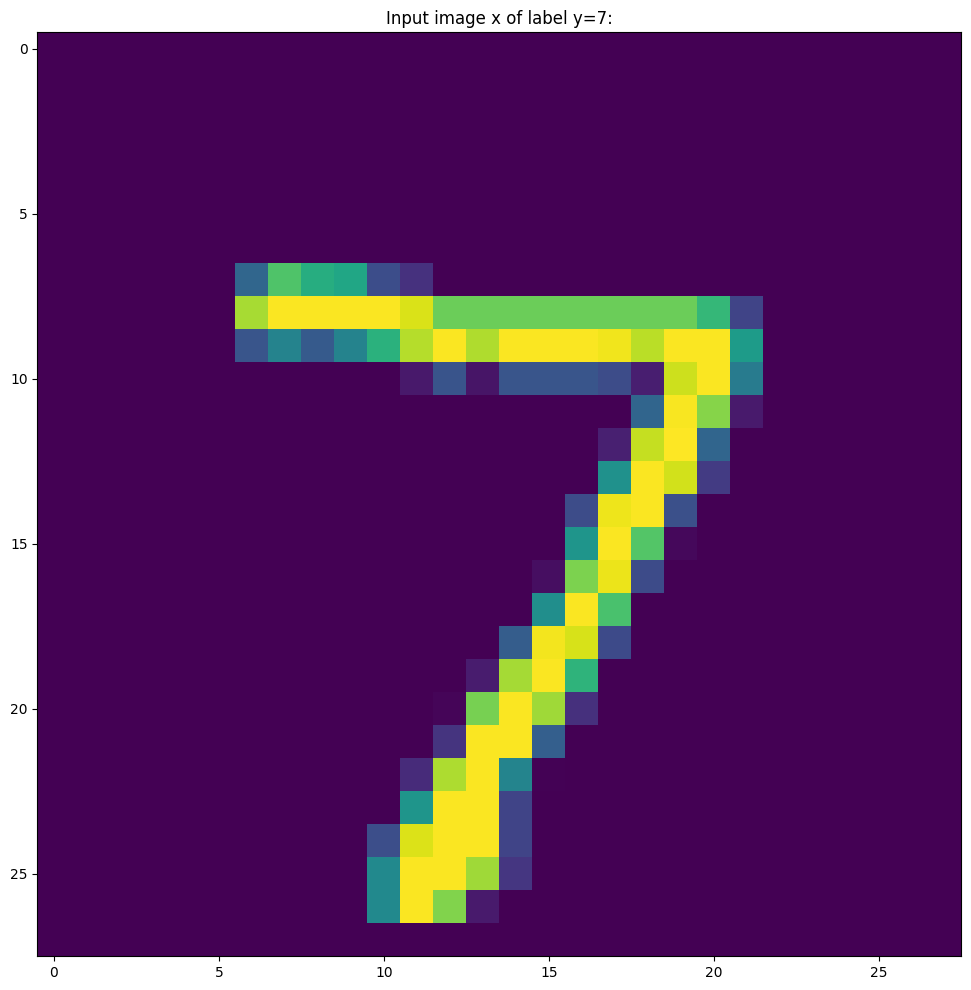

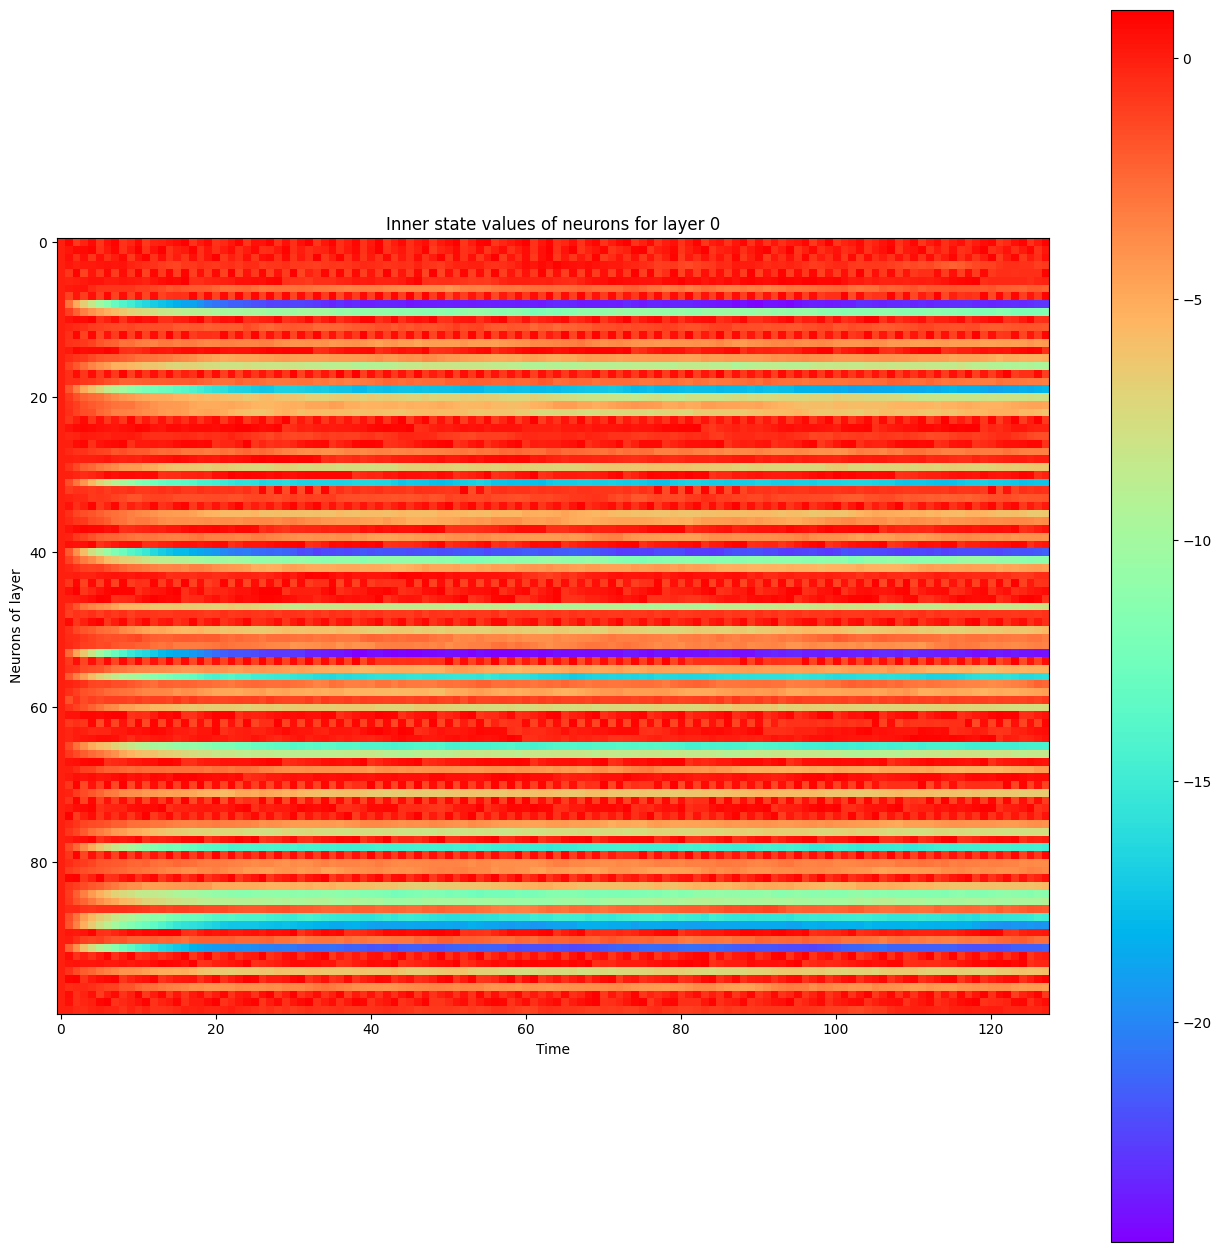

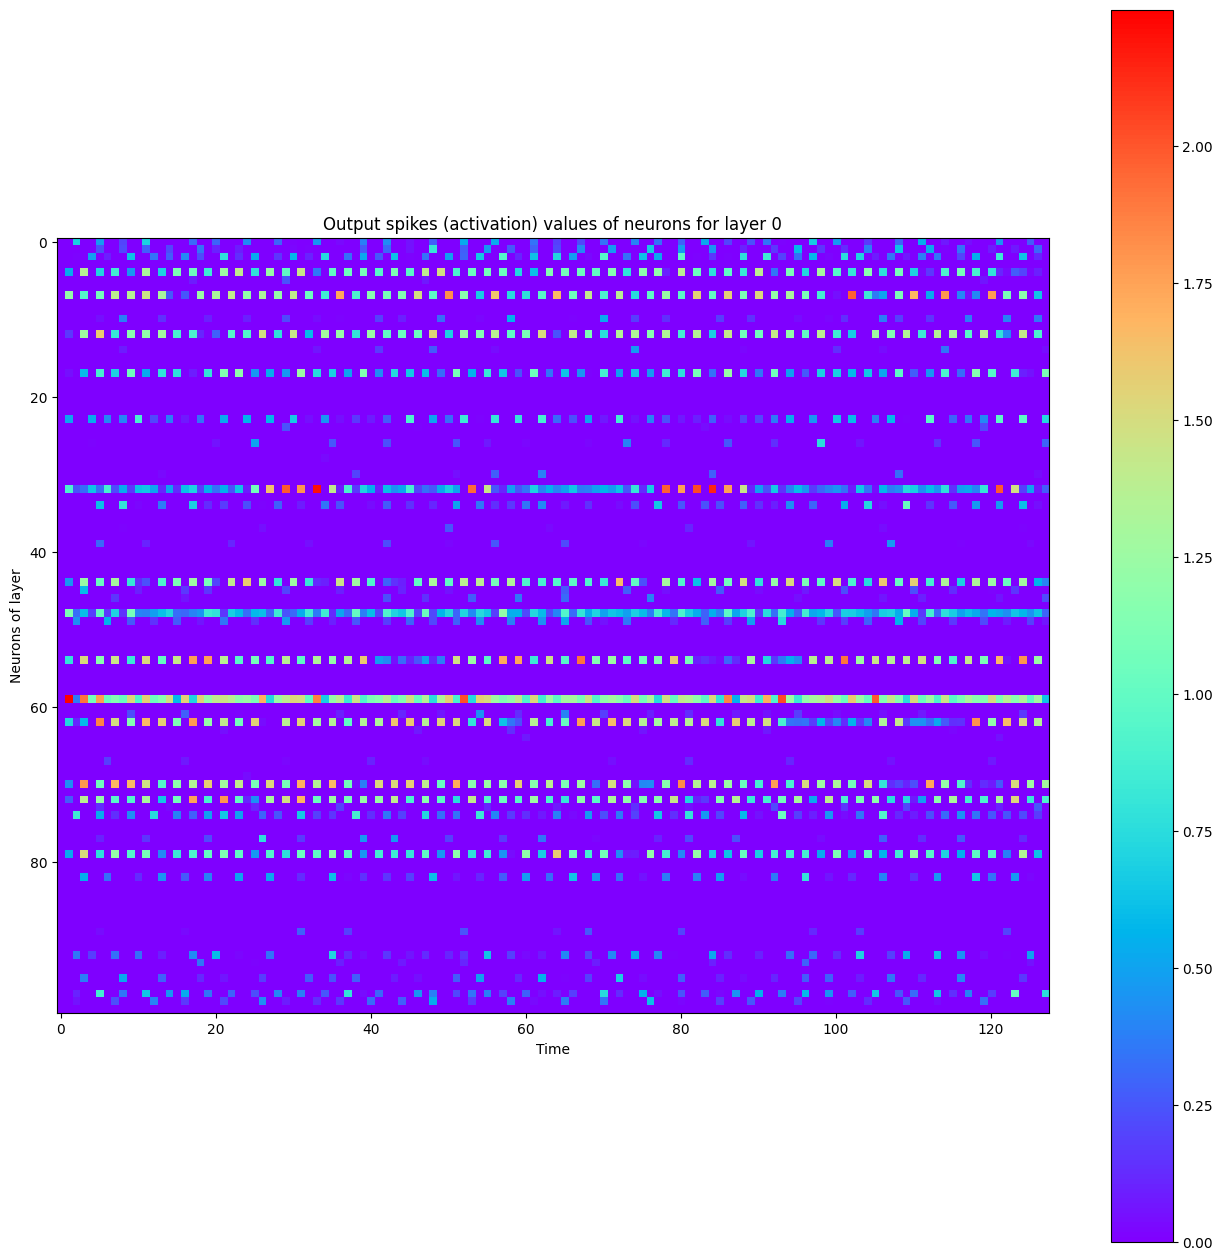

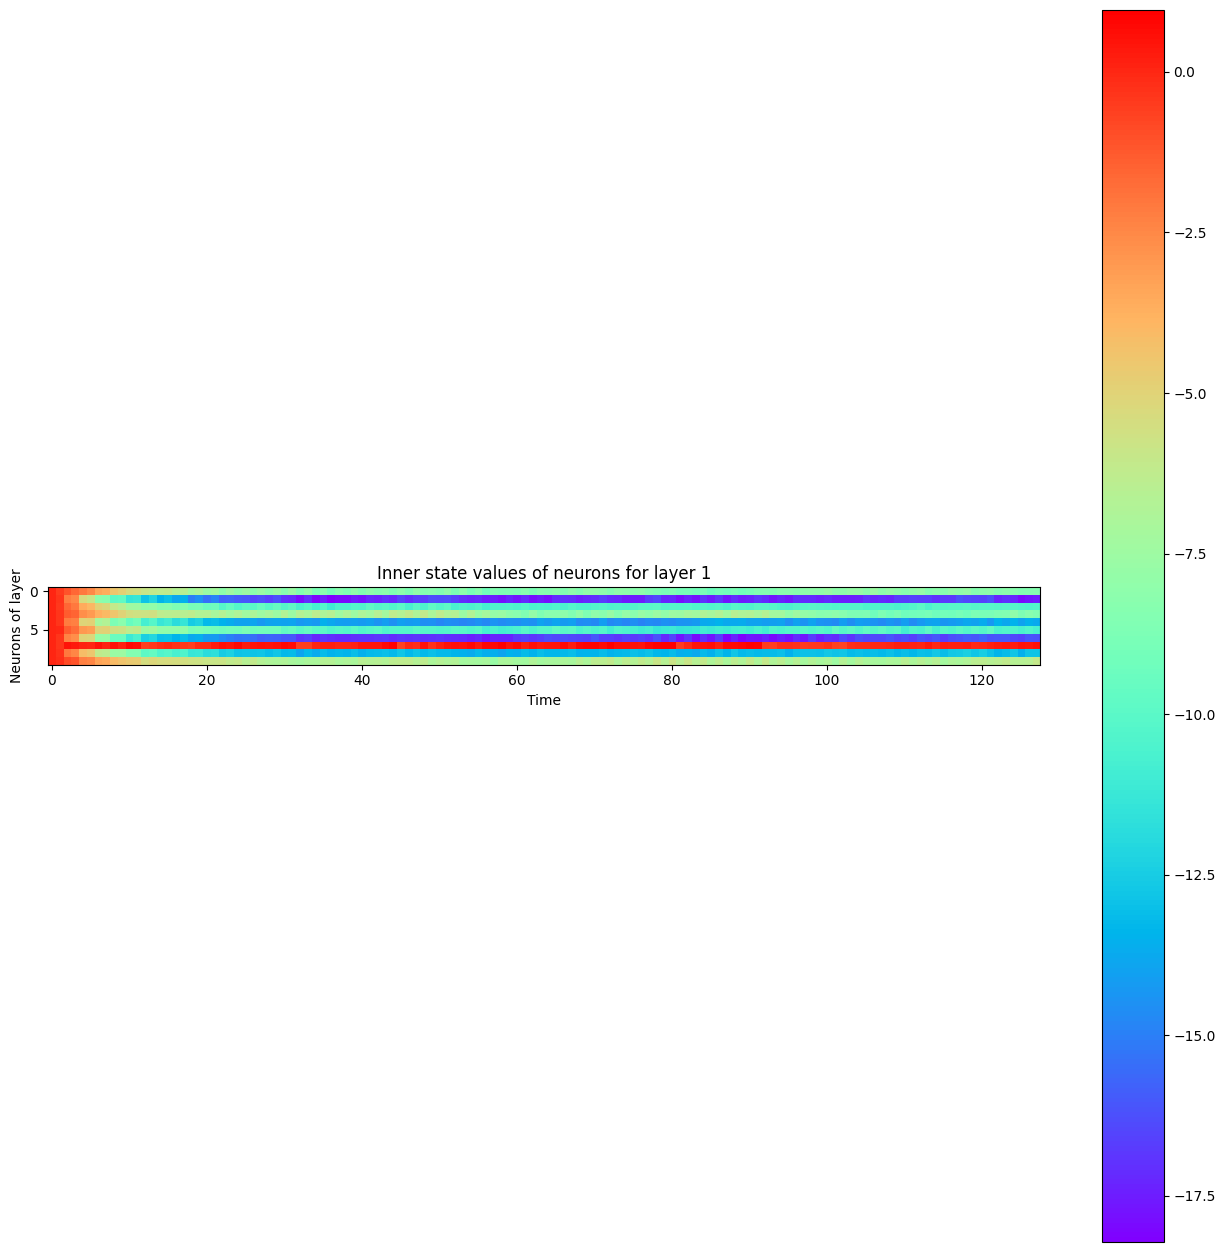

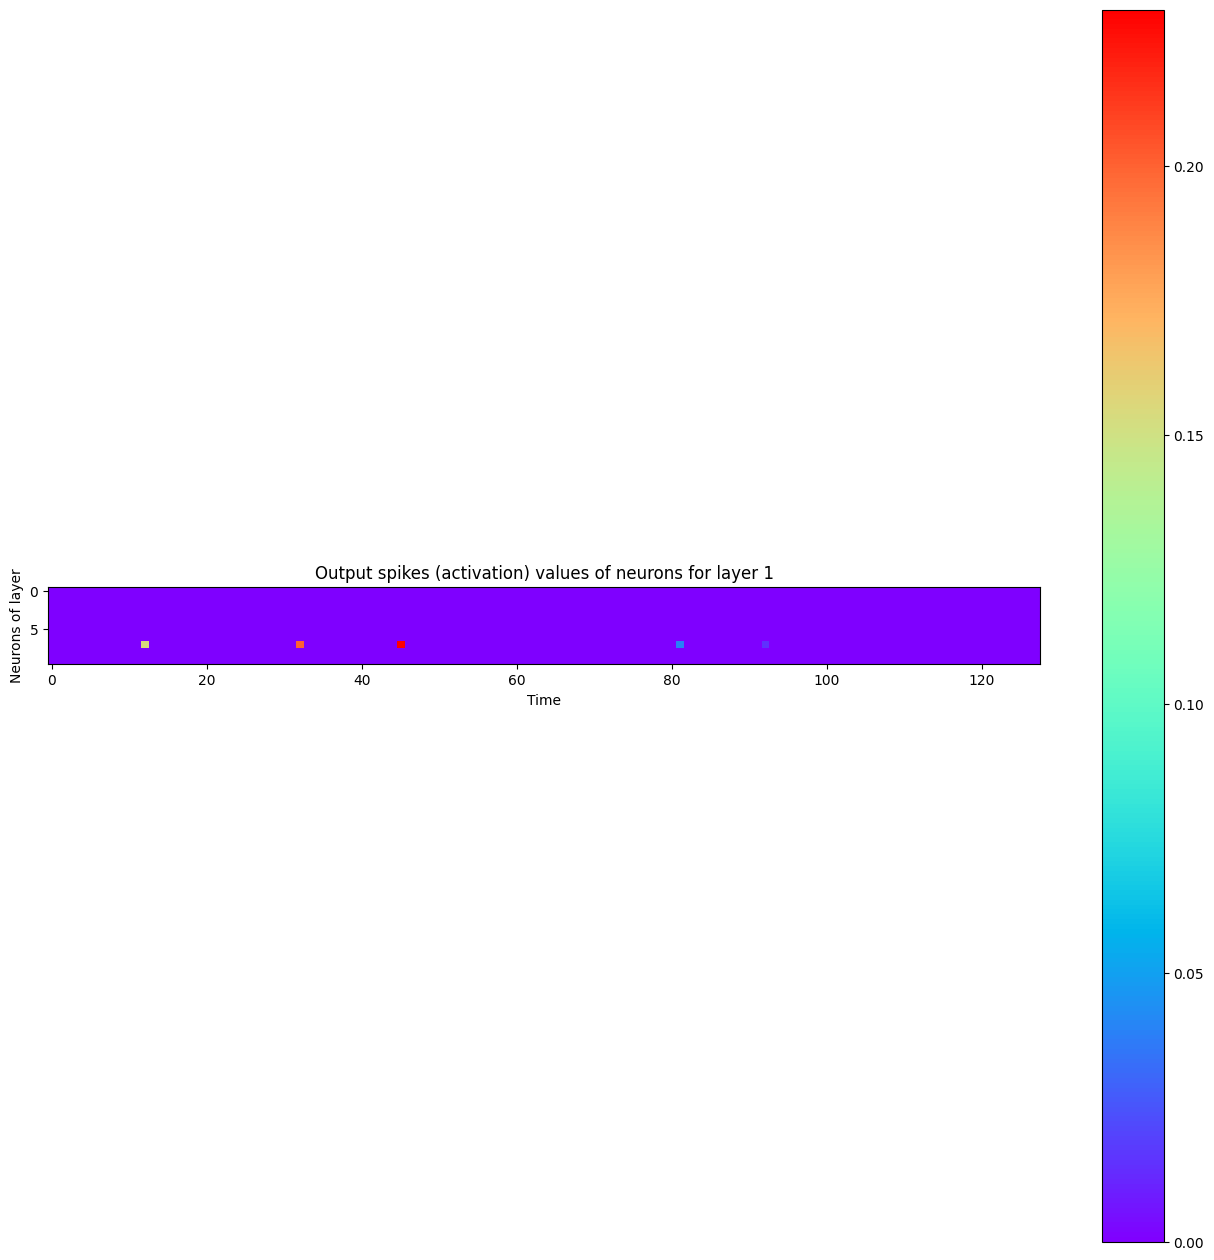

A hidden neuron that looks excited:


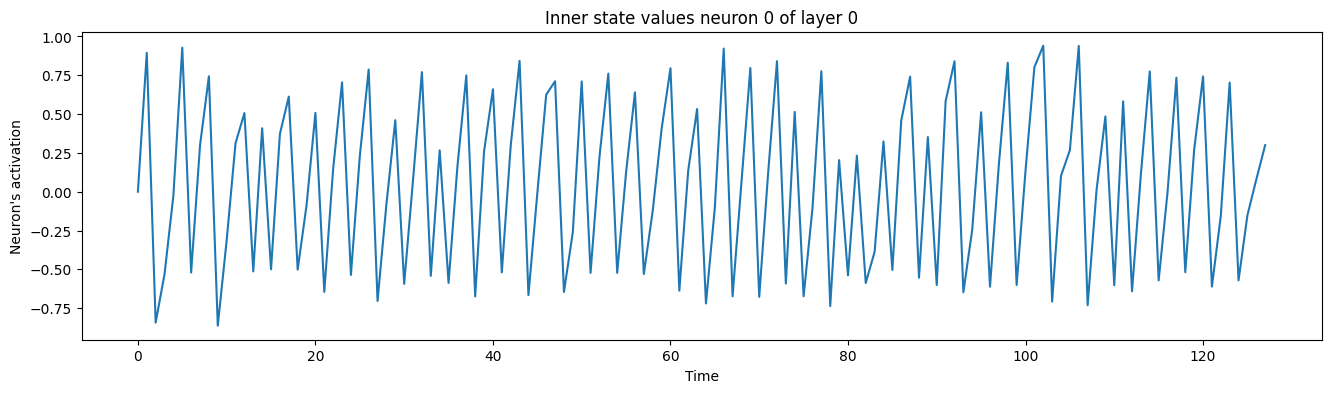

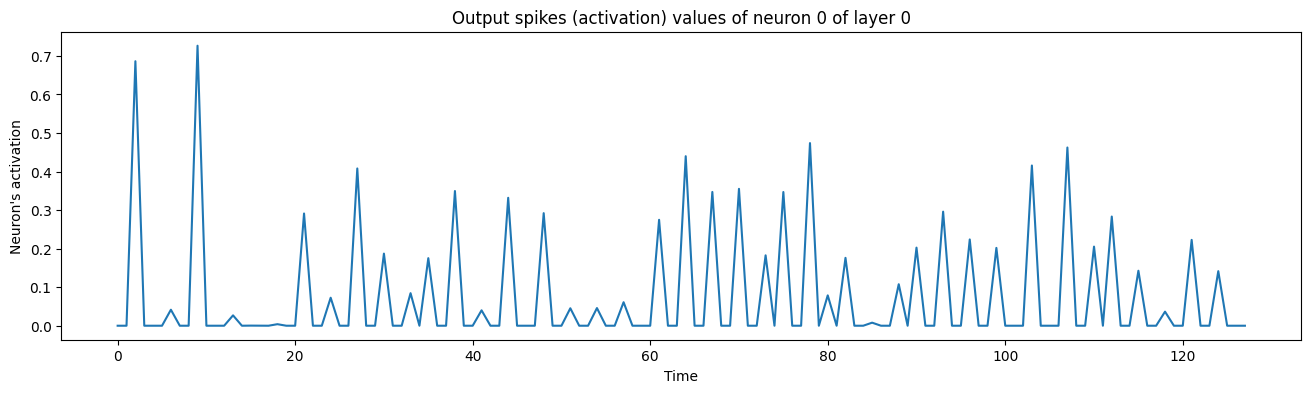

The output neuron of the label:


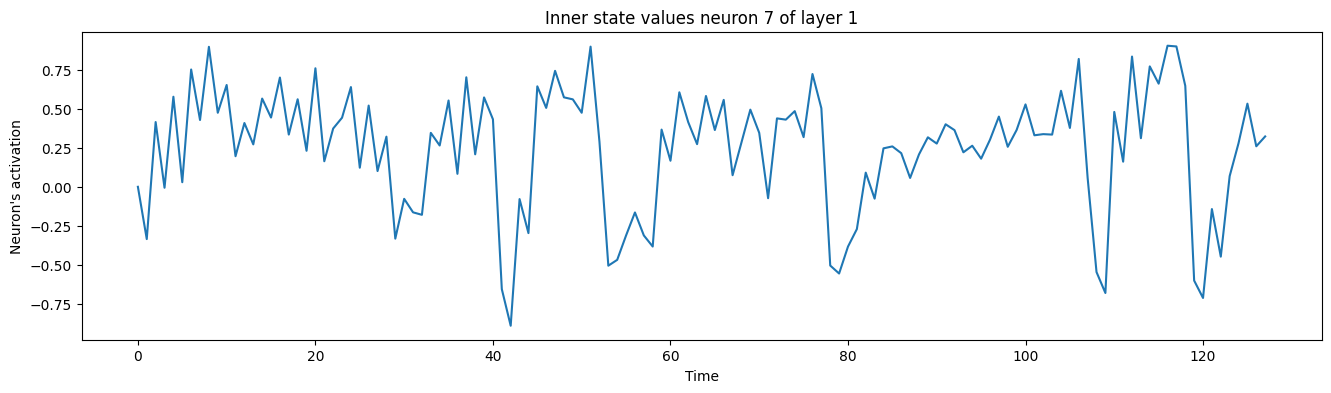

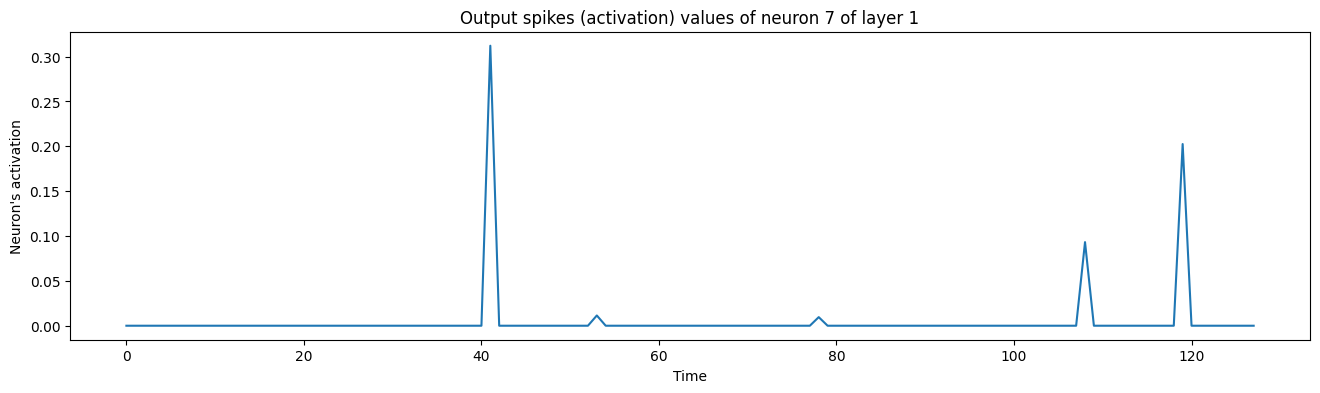

In [ ]:
data, target = test_set_loader.__iter__().__next__()

# taking 1st testing example:
x = torch.stack([data[0]])
y = target.data.numpy()[0]
plt.figure(figsize=(12,12))
plt.imshow(x.data.cpu().numpy()[0,0])
plt.title("Input image x of label y={}:".format(y))
plt.show()

# plotting neuron's activations:
spiking_model.visualize_all_neurons(x)
print("A hidden neuron that looks excited:")
spiking_model.visualize_neuron(x, layer_idx=0, neuron_idx=0)
print("The output neuron of the label:")
spiking_model.visualize_neuron(x, layer_idx=1, neuron_idx=y)


PCA


In [2]:
# PCA taken from:
# https://glowingpython.blogspot.com/2011/07/principal-component-analysis-with-numpy.html

# When running PCA:
# The variables are the times
# The observations are the channels

import numpy as np
import itertools
from typing import List
import sys

def princomp(A):
    """
    Performs principal components analysis (PCA) on the n-by-p data matrix A.
    Rows of A correspond to observations, columns to variables.

    Returns :
    coeff :
        is a p-by-p matrix, each column containing coefficients for one
        principal component.
    score :
        the principal component scores; that is, the representation of A in the
        principal component space. Rows of SCORE correspond to observations,
        columns to components.
    latent :
        a vector containing the eigenvalues of the covariance matrix of A.
    """
    # computing eigenvalues and eigenvectors of covariance matrix
    M = (A-np.mean(A.T,axis=1)).T # subtract the mean (along columns)
    [latent,coeff] = np.linalg.eig(np.cov(M)) # attention:not always sorted
    score = np.dot(coeff.T,M) # projection of the data in the new space
    return (coeff, score, latent)

def readFileSequence(fileNames):
    allFiles = [np.fromfile(f, dtype=np.dtype('i4')) for f in fileNames]
    return np.concatenate(allFiles)


def makeChannelMatrix(fileNames):
    channelNames = []
    observations = []
    fileGroups = itertools.groupby(fileNames, lambda name: name.split("-")[0])
    for (channelName, fileNames) in fileGroups:
        channelNames.append(channelName)
        observationRow = readFileSequence(fileNames)
        observationRowMatrix = np.reshape(observationRow, (-1, observationRow.shape[0]))
        observations.append(observationColumn)
    channelMatrix = np.concatenate(observations)
    print(channelMatrix.shape)
    return channelMatrix

def readRow2D(fileName):
    row1d = np.fromfile('v40p.mat', dtype=np.dtype('i4'))
    row2d = np.reshape(row1d, (-1, row1d.shape[0]))
    return row2d

def makeSingleSliceMatrix(fileNames):
    return np.concatenate(list(map(readRow2D, fileNames)))

def performPCA(fileNames):
    pcaMatrix = makeSingleSliceMatrix(fileNames)
    coeff, score, latent = princomp(pcaMatrix)
    component1 = np.asarray((coeff[:, 1] * 1000000).round(), dtype=np.int32)
    outputName = 'PCA-' + '-'.join(fileNames[0].split('-')[1:])
    component1.tofile(outputName)

performPCA(sys.argv[1:])

FileNotFoundError: ignored

In [ ]:
import results
from results import CombinedResults
from viz_utils import print_confusion_matrix, get_roc, combine_subjects, plot_acc_or_loss, get_mean, scattered_boxplot
from utils import get_class_labels, load_pickle
import numpy as np
import pandas as pd

direct = '/content/drive/MyDrive/Capstone/ADHD/v40p.mat'
subjects = ["01", "02"]
paradigm = "EEG_semantics_text"
filename = "combineResults"
identifier="all_subjects"
n_folds = 2

# Load pre-compiled Results object containing all combined-subject results
total_results, _ = load_pickle(f"{direct}/results/",f"{paradigm.replace('EEG_','')}",f"{filename}.pickle")
total_results = total_results['subject']

print(f"               Combined results for paradigm: {total_results.paradigm.replace('EEG_','')}")
print(total_results.subject_stats_df.head())


print_confusion_matrix(total_results.cm, labels, f"C:/Users/sb00745777/OneDrive - Ulster University/Study_3/Subject_Data/results/{paradigm.replace('EEG_','')}/confusion_matrix")

get_roc(total_results.y_pred, total_results.y_true, labels,
         filename=f"{direct}/results/{paradigm.replace('EEG_','')}/roc_curve", show_plot=True)

# Plot and save losses
mean_loss_train, mean_loss_valid, mean_loss_test = get_mean(total_results, metric="loss")
mean_acc_train, mean_acc_valid, mean_acc_test = get_mean(total_results, metric="acc")
x = mean_loss_train.index.tolist()
x = [n+1 for n in x]
plot_acc_or_loss(x, mean_loss_train, mean_loss_valid, mean_loss_test, ylabel="Loss", filename=f"{direct}/results/{paradigm.replace('EEG_','')}/loss_plot", show_plot=True)
plot_acc_or_loss(x, mean_acc_train, mean_acc_valid, mean_acc_test, ylabel="Accuracy", filename=f"{direct}/results/{paradigm.replace('EEG_','')}/acc_plot", show_plot=True)


##### Draw box plots with data scattered across
inner_box_acc_data = total_results.HP_acc['Mean'].values
inner_box_loss_data = total_results.HP_loss['Mean'].values
inner_box_ce_data = total_results.HP_ce['Mean'].values

scattered_boxplot(inner_box_acc_data, xlabel=paradigm.replace('EEG_',''), ylabel='Classification Accuracy (%)',
                  filename=f"{direct}/results/{paradigm.replace('EEG_','')}/acc_scatterbox", show_plot=True)
scattered_boxplot(inner_box_loss_data, xlabel=paradigm.replace('EEG_',''), ylabel='Loss',
                  filename=f"{direct}/results/{paradigm.replace('EEG_','')}/loss_scatterbox", show_plot=True)
scattered_boxplot(inner_box_ce_data, xlabel=paradigm.replace('EEG_',''), ylabel='Cross Entropy',
                  filename=f"{direct}/results/{paradigm.replace('EEG_','')}/crossentropy_scatterbox", show_plot=True)

ModuleNotFoundError: ignored

In [ ]:
%%capture
!pip install ssqueezepy
!pip install timm
!pip install pytorch-lightning

In [ ]:
main_path='/content/drive/MyDrive/Capstone/ADHD/v40p.mat'

In [ ]:
import pandas as pd
import os
df=pd.read_csv(os.path.join(main_path,'EEG_data.csv'))
df.head()

FileNotFoundError: ignored

ICA


In [ ]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 15.2 MB/s eta 0:00:00


In [ ]:
%matplotlib notebook
import mne
import matplotlib.pyplot as plt

In [ ]:
dir(raw)

['__class__',
 '__contains__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_annotations',
 '_cals',
 '_check_bad_segment',
 '_comp',
 '_cropped_samp',
 '_data',
 '_dtype',
 '_dtype_',
 '_extra_attributes',
 '_filenames',
 '_first_samps',
 '_first_time',
 '_get_buffer_size',
 '_get_channel_positions',
 '_getitem',
 '_handle_tmin_tmax',
 '_init_kwargs',
 '_last_samps',
 '_last_time',
 '_orig_units',
 '_parse_get_set_params',
 '_pick_drop_channels',
 '_pick_projs',
 '_preload_data',
 '_projector',
 '_projectors',
 '_raw_extras',
 '_raw_lengths',
 '_read_comp_grade',
 '_read_picks',
 '_read_segment',

In [ ]:
raw.filter

<bound method BaseRaw.filter of <RawArray | 19 x 20097 (157.0 s), ~2.9 MB, data loaded>>

In [ ]:
 raw.filter(8, 30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 213 samples (1.664 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


<RawArray | 19 x 20097 (157.0 s), ~2.9 MB, data loaded>

In [ ]:
raw.plot?

In [ ]:
raw.plot( events=None, start=5.0, duration=10.0, color='gray',n_channels=19,block=True, scalings='auto');

NameError: ignored

In [ ]:
ica=mne.preprocessing.ICA(n_components=19, random_state=0)

In [ ]:
ica.fit(raw.copy().filter(8,35))

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 213 samples (1.664 s)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 3.6s.


Method,fastica
Fit,48 iterations on raw data (20097 samples)
ICA components,19
Available PCA components,19
Channel types,eeg
ICA components marked for exclusion,—


In [1]:


# Load your EEG data into a Raw object (replace 'raw_file_path' with the actual path to your EEG data file)
raw = mne.io.read_raw_fif(raw_file_path, preload=True)

# Read the EEG electrode montage (replace 'standard_1005' with the desired montage name)
montage = mne.channels.read_montage('standard_1005')

# Set the montage for the Raw object
raw.set_montage(montage)

# Now you can use the raw.plot() function to visualize the EEG data with the montage
raw.plot()


NameError: ignored

In [ ]:

montage = mne.channels.read_montage(kind='v40p.mat', ch_names=None, path='/content/drive/MyDrive/Capstone/ADHD/v40p.mat', unit='m', transform=False)
print(montage)

raw.set_montage(montage, set_dig=True)

AttributeError: ignored

In [ ]:
ica.plot_components(outlines="skirt")

RuntimeError: ignored

In [ ]:
raw.get_data().shape